In [1]:
# Import the necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download historical data
data = yf.download('CBA.AX', start='2021-01-01', end='2025-04-02', group_by='ticker')['CBA.AX']

# Keep only the closing prices column+
data = data[['Close']]

# Calculate daily percentage returns
data['Returns'] = data['Close'].pct_change()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
def find_integration_order(series):
   """Determine the order of integration (d) using Augmented Dickey-Fuller test"""
   d = 0  # Initialize differencing order
   while True:
       # Perform ADF test
       result = adfuller(series, autolag='AIC') 
       # Check if p-value <= 5% (stationary)
       if result[1] <= 0.05: 
           # Return current differencing order if stationary
           return d 
       # Difference the series
       series = series.apply(np.log).diff().dropna() 
       # Increment differencing order
       d += 1 
       # Safety check to prevent over-differencing
       if d >= 2:
           return d


def select_arima_order(train, d):
   """Select best ARIMA (p,d,q) parameters using Akaike Information Criterion"""
   ps = range(0, 6)  # Test AR orders from 0 to 2
   qs = range(0, 6)  # Test MA orders from 0 to 2
   best_aic = np.inf  # Initialize with worst possible AIC
   best_order = (0, d, 0)  # Default order
  
   # Make series stationary if differencing required
   if d > 0:
       train = train.apply(np.log).diff(d).dropna()
  
   # Grid search over p and q combinations
   for p, q in product(ps, qs):
       if (p==0) and (q==0):
           continue
       try:
           # Initialize ARIMA model
           model = ARIMA(train, order=(p, d, q)) 
           # Fit model to training data
           results = model.fit() 
           # Check if current model is better
           if results.aic < best_aic:
               # Update best AIC
               best_aic = results.aic 
               # Update best order
               best_order = (p, d, q) 
       except:
           # Skip invalid parameter combinations
           continue 
   return best_order

In [4]:
# Set the position: 1 for long, 0 for no position
data['position'] = 0  

# Placeholder for active ARIMA model
current_model = None

# Track last model update date
last_fit_date = None

# Set the span to train the ARIMA model each day
train_span = 126

# Set the year to start trading
year_start = 2022

In [ ]:
# Main event-driven backtesting loop
for date, row in data[data.index.year>=year_start].iterrows():
   # Check if it's Monday and we have sufficient historical data
   if (date.weekday() == 0) and (len(data[:date]) > train_span):
       try:
           # Determine integration order using entire history up to current date
           d = find_integration_order(data.loc[:date,'Close'].iloc[-train_span:])
          
           # Select optimal ARIMA parameters
           p, _, q = select_arima_order(data.loc[:date,'Close'].iloc[-train_span:], d)
          
           # Fit ARIMA model with selected parameters
           model = ARIMA(data.loc[:date,'Close'].iloc[-train_span:], order=(p, d, q))
           current_model = model.fit()  # Store fitted model
           last_fit_date = date  # Update last fit date
       except Exception as e:
           print(f"Error fitting model on {date}: {e}")
           continue
  
   # Generate trading signals when we have a valid model
   if current_model and date > last_fit_date:
       try:
           # Get one-step ahead forecast
           forecast = current_model.get_forecast(steps=1)
           pred = forecast.predicted_mean.iloc[0]  # Extract predicted value
           current_price = np.log(row['Close'])  # Get current closing price
          
           # Determine position based on forecast vs current price
           if pred > current_price:
               data.loc[date, 'position'] = 1  # Long signal
           else:
               data.loc[date, 'position'] = 0  # No position
       except:
           data.loc[date, 'position'] = 0  # No position on error

In [6]:
# Subset the dataframe to use the forecast-signal data only
subsample = data[data.index.year>=year_start].copy()
# Vectorized returns calculation
subsample['position'] = subsample['position'].shift(1)  # Trade next day
subsample['Strategy_Returns'] = subsample['position'] * subsample['Returns']


# Calculate cumulative returns
subsample['Cumulative_Strategy'] = (1 + subsample['Strategy_Returns']).cumprod()
subsample['Cumulative_BH'] = (1 + subsample['Returns']).cumprod()

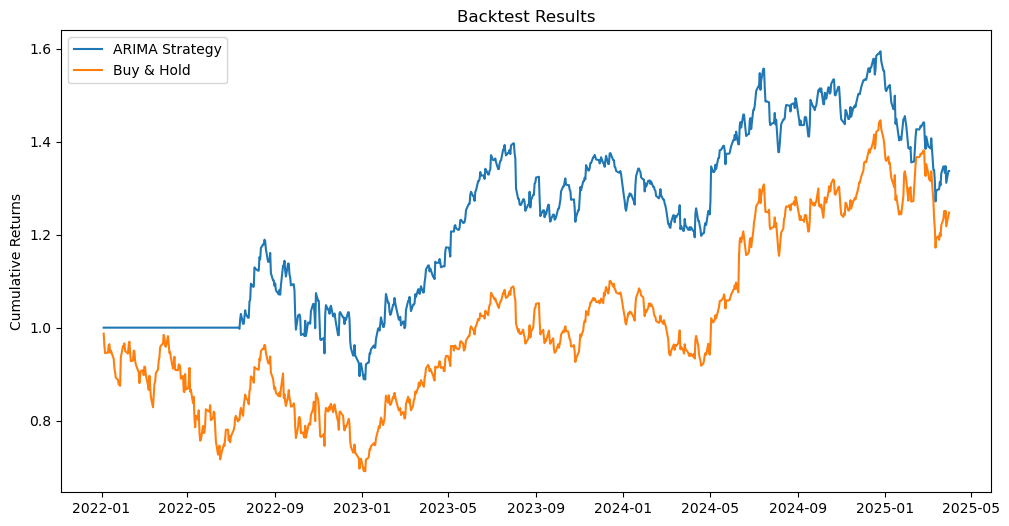

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(subsample['Cumulative_Strategy'], label='ARIMA Strategy')
plt.plot(subsample['Cumulative_BH'], label='Buy & Hold')
plt.title('Backtest Results')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()